In [279]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/diploma/data.csv


In [280]:
# импорт библиотек

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import sys
import zipfile
import PIL
from PIL import ImageOps, ImageFilter
import re
import ast
from datetime import time, date, datetime
import random

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('seaborn-paper')


from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_predict, cross_val_score
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, MinMaxScaler, StandardScaler, RobustScaler

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import BaggingRegressor
from sklearn.metrics import mean_squared_error, f1_score, accuracy_score, roc_curve, roc_auc_score
from sklearn import metrics
from sklearn.ensemble import StackingRegressor
from sklearn.ensemble import VotingRegressor
from tqdm.notebook import tqdm
from catboost import CatBoostRegressor, Pool, cv

# keras
import tensorflow as tf
import tensorflow.keras.backend as K
import tensorflow.keras.layers as L
from tensorflow.keras.models import Model, Sequential

from tensorflow.keras.losses import MeanAbsolutePercentageError

#from transformers import AutoTokenizer, TFAutoModelForSequenceClassification, DataCollatorWithPadding

# Suppress warnings 
import warnings
warnings.filterwarnings('ignore')


pd.set_option('display.max_columns', 550) # больше колонок

os.environ['PYTHONHASHSEED']=str(42)

In [281]:
RANDOM_SEED = 42
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)
ITERATIONS = 200

In [282]:
DIR_DATA  = '../input/diploma/'

In [283]:
data_d = pd.read_csv(DIR_DATA+'data.csv')

# Вспомогательные функции расчета метрик.

In [284]:
# Функция расчета ошибки
def mape(y_true, y_pred):
    return np.mean(np.abs((y_pred-y_true)/y_true))

In [285]:
# Функция расчета ошибки для логарифмированной целевой переменнной
def mape_log(y_true, y_pred):
    return np.mean(np.abs((np.exp(y_pred)-np.exp(y_true))/np.exp(y_true)))

In [286]:
def print_regression_metrics(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    print(f'MSE = {mse:.2f}, RMSE = {rmse:.2f}')

In [287]:
data_d.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 377185 entries, 0 to 377184
Data columns (total 18 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   status        337267 non-null  object
 1   private pool  4181 non-null    object
 2   propertyType  342452 non-null  object
 3   street        377183 non-null  object
 4   baths         270847 non-null  object
 5   homeFacts     377185 non-null  object
 6   fireplace     103115 non-null  object
 7   city          377151 non-null  object
 8   schools       377185 non-null  object
 9   sqft          336608 non-null  object
 10  zipcode       377185 non-null  object
 11  beds          285903 non-null  object
 12  state         377185 non-null  object
 13  stories       226470 non-null  object
 14  mls-id        24942 non-null   object
 15  PrivatePool   40311 non-null   object
 16  MlsId         310305 non-null  object
 17  target        374704 non-null  object
dtypes: object(18)
memory usa

# Анализ целевой переменной.

# Вспомогательная функция извлечения числа из записи доллара.

In [288]:
def dollar_clean(string):
    i=0
    string_interm=re.findall('[0-9]+', string)
    
    if string_interm==[]:

        return np.NaN
    else:
        dollar_res=''
        while i<=(len(string_interm)-1):
            dollar_res=dollar_res + string_interm[i]
            i=i+1
        return float(dollar_res)


In [289]:
data_d.target = data_d.target.apply(lambda x: dollar_clean(str(x)))

In [290]:
data_d['target'].isna().unique()

array([False,  True])

In [291]:
data_d.loc[data_d['target'].isna() == True]

,status,private pool,propertyType,street,baths,homeFacts,fireplace,city,schools,sqft,zipcode,beds,state,stories,mls-id,PrivatePool,MlsId,target
61,NaN,NaN,Single Family,7353 Boysenberry Ct,2.0,"{'atAGlanceFacts': [{'factValue': '1983', 'fac...",Yes,Jacksonville,"[{'rating': ['7/10', '2/10', '4/10'], 'data': ...","1,446 sqft",32244,3,FL,1,NaN,NaN,NaN,NaN
94,Pre-foreclosure / auction,NaN,Townhouse,20663 Fm 2154 Rd,Bathrooms: 4,"{'atAGlanceFacts': [{'factValue': '2016', 'fac...",Yes,College Station,"[{'rating': ['NA', '2/10', 'NA'], 'data': {'Di...","Total interior livable area: 4,179 sqft",77845,4 bd,TX,2.0,NaN,NaN,NaN,NaN
121,/ auction,NaN,Single Family,3719 Suffolk St,2,"{'atAGlanceFacts': [{'factValue': '1972', 'fac...",Yes,Durham,"[{'rating': ['2/10', '5/10', '4/10'], 'data': ...","2,327",27707,3,NC,0.0,NaN,NaN,NaN,NaN
169,NaN,NaN,Single Family,8201 Waterford Ave,2.0,"{'atAGlanceFacts': [{'factValue': '1985', 'fac...",NaN,Tamarac,"[{'rating': ['4/10', '5/10', '5/10'], 'data': ...","1,280 sqft",33321,2,FL,1.0,NaN,NaN,NaN,NaN
174,Pre-foreclosure / auction,NaN,Single Family,17508 Puritas Ave,Bathrooms: 2,"{'atAGlanceFacts': [{'factValue': '2006', 'fac...",NaN,Cleveland,"[{'rating': ['2/10', '2/10'], 'data': {'Distan...","Total interior livable area: 1,209 sqft",44135,2 bd,OH,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
376495,recently sold,NaN,single-family home,7433 Creekland Dr,2 Baths,"{'atAGlanceFacts': [{'factValue': '2003', 'fac...",NaN,Reno,"[{'rating': ['None/10', '5/10', '3/10'], 'data...","1,082 sqft",89506,2 Beds,NV,1,NaN,NaN,NaN,NaN
376528,foreclosure,NaN,apartment,5652 S Justine St,2 Baths,"{'atAGlanceFacts': [{'factValue': '2009', 'fac...",NaN,Chicago,"[{'rating': ['1/10', '1/10', '2/10'], 'data': ...","2,351 sqft",60636,6 Beds,IL,NaN,NaN,NaN,NaN,NaN
376577,Foreclosed,NaN,Single Family,1851 W Landstreet Rd # 3233,NaN,"{'atAGlanceFacts': [{'factValue': '1973', 'fac...",NaN,Orlando,"[{'rating': ['4/10', '2/10', '5/10'], 'data': ...",Total interior livable area: 620 sqft,32809,-- bd,FL,NaN,NaN,NaN,NaN,NaN
376937,NaN,NaN,NaN,8501 NW 53rd Ter,NaN,"{'atAGlanceFacts': [{'factValue': None, 'factL...",NaN,Doral,"[{'rating': ['10/10', '8/10'], 'data': {'Dista...",NaN,33166,1.74 acres,FL,NaN,NaN,NaN,NaN,NaN


In [292]:
data_d.dropna(axis=0,subset=['target'],inplace=True)

In [293]:
data_d['target'].isna().unique()

array([False])

<AxesSubplot:xlabel='target', ylabel='Density'>

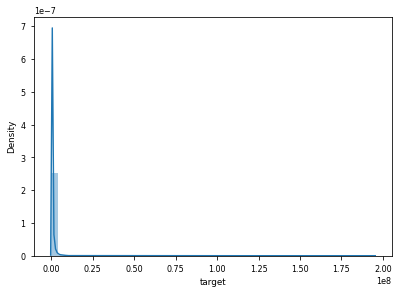

In [294]:
sns.distplot(data_d['target'])

# Удаление выбросов в целевой переменной.

In [295]:
data_d.loc[data_d['target'].median()]

status                                                     Active
private pool                                                  NaN
propertyType                        Condo/Townhome/Row Home/Co-Op
street                              1080 Wisconsin Ave NW Apt 304
baths                                                         1.5
homeFacts       {'atAGlanceFacts': [{'factValue': '1981', 'fac...
fireplace                                                     NaN
city                                                   Washington
schools         [{'rating': ['8', '8', '8', '8', '9', '9', 'NR...
sqft                                                          946
zipcode                                                     20007
beds                                                            1
state                                                          DC
stories                                                        3+
mls-id                                                        NaN
PrivatePoo

In [296]:
data_d['target'].mean()

644757.5030263888

In [297]:
data_d.loc[data_d['target']>data_d['target'].mean()]

,status,private pool,propertyType,street,baths,homeFacts,fireplace,city,schools,sqft,zipcode,beds,state,stories,mls-id,PrivatePool,MlsId,target
2,for sale,NaN,single-family home,2005 Westridge Rd,2 Baths,"{'atAGlanceFacts': [{'factValue': '1961', 'fac...",yes,Los Angeles,"[{'rating': ['8/10', '4/10', '8/10'], 'data': ...","3,000 sqft",90049,3 Beds,CA,1.0,NaN,yes,FR19221027,2895000.0
3,for sale,NaN,single-family home,4311 Livingston Ave,8 Baths,"{'atAGlanceFacts': [{'factValue': '2006', 'fac...",yes,Dallas,"[{'rating': ['9/10', '9/10', '10/10', '9/10'],...","6,457 sqft",75205,5 Beds,TX,3.0,NaN,NaN,14191809,2395000.0
10,for sale,NaN,coop,14205 Roosevelt Ave #512,2 Baths,"{'atAGlanceFacts': [{'factValue': '1965', 'fac...",NaN,Flushing,"[{'rating': ['2/10', '8/10', '10/10'], 'data':...","1,300 sqft",11354,3 Beds,NY,NaN,NaN,NaN,3087630,669000.0
15,New,NaN,2 Story,930 52nd St,NaN,"{'atAGlanceFacts': [{'factValue': '1905', 'fac...",NaN,Brooklyn,"[{'rating': ['8', '8', '3'], 'data': {'Distanc...",NaN,11219,NaN,NY,NaN,NaN,NaN,3182740,1650000.0
17,Active,NaN,Townhouse,24 W 126th St,NaN,"{'atAGlanceFacts': [{'factValue': '1899', 'fac...",NaN,New York,"[{'rating': ['2', '5', '1', '2'], 'data': {'Di...","3,325",10027,NaN,NY,NaN,NaN,NaN,4975368,2650000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
377168,for sale,NaN,single-family home,24080 Tuscany Ct,5 Baths,"{'atAGlanceFacts': [{'factValue': '2006', 'fac...",yes,Bonita Springs,"[{'rating': ['3/10', '8/10', '4/10', '5/10', '...","5,992 sqft",34134,4 Beds,FL,NaN,NaN,yes,219077435,2495000.0
377174,for sale,NaN,single-family home,1107 E Euclid Ave,NaN,"{'atAGlanceFacts': [{'factValue': '1938', 'fac...",NaN,San Antonio,"[{'rating': ['4/10', '5/10', '3/10'], 'data': ...",950 sqft,78212,2 Beds,TX,1.0,NaN,yes,1391618,799500.0
377179,For sale,NaN,Condo,2238 11th St NW APT 2,3,"{'atAGlanceFacts': [{'factValue': '2010', 'fac...",NaN,Washington,"[{'rating': ['3/10', '3/10'], 'data': {'Distan...","1,417",20001,2,DC,3.0,NaN,NaN,DCDC444306,799000.0
377180,NaN,NaN,Single Family,20800 NE 23rd Ave,6.0,"{'atAGlanceFacts': [{'factValue': '1990', 'fac...",NaN,Miami,"[{'rating': ['10/10', '5/10'], 'data': {'Dista...","4,017",33180,5,FL,0.0,NaN,Yes,A10702700,1249000.0


In [298]:
data_d.loc[data_d['target']>500000]

,status,private pool,propertyType,street,baths,homeFacts,fireplace,city,schools,sqft,zipcode,beds,state,stories,mls-id,PrivatePool,MlsId,target
2,for sale,NaN,single-family home,2005 Westridge Rd,2 Baths,"{'atAGlanceFacts': [{'factValue': '1961', 'fac...",yes,Los Angeles,"[{'rating': ['8/10', '4/10', '8/10'], 'data': ...","3,000 sqft",90049,3 Beds,CA,1.0,NaN,yes,FR19221027,2895000.0
3,for sale,NaN,single-family home,4311 Livingston Ave,8 Baths,"{'atAGlanceFacts': [{'factValue': '2006', 'fac...",yes,Dallas,"[{'rating': ['9/10', '9/10', '10/10', '9/10'],...","6,457 sqft",75205,5 Beds,TX,3.0,NaN,NaN,14191809,2395000.0
10,for sale,NaN,coop,14205 Roosevelt Ave #512,2 Baths,"{'atAGlanceFacts': [{'factValue': '1965', 'fac...",NaN,Flushing,"[{'rating': ['2/10', '8/10', '10/10'], 'data':...","1,300 sqft",11354,3 Beds,NY,NaN,NaN,NaN,3087630,669000.0
12,for sale,NaN,single-family home,16373 NW 16th St,3 Baths,"{'atAGlanceFacts': [{'factValue': '1996', 'fac...",NaN,Pembroke Pines,"[{'rating': ['8/10', '7/10', '7/10'], 'data': ...","2,839 sqft",33028,4 Beds,FL,1.0,NaN,yes,A10767242,525000.0
15,New,NaN,2 Story,930 52nd St,NaN,"{'atAGlanceFacts': [{'factValue': '1905', 'fac...",NaN,Brooklyn,"[{'rating': ['8', '8', '3'], 'data': {'Distanc...",NaN,11219,NaN,NY,NaN,NaN,NaN,3182740,1650000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
377174,for sale,NaN,single-family home,1107 E Euclid Ave,NaN,"{'atAGlanceFacts': [{'factValue': '1938', 'fac...",NaN,San Antonio,"[{'rating': ['4/10', '5/10', '3/10'], 'data': ...",950 sqft,78212,2 Beds,TX,1.0,NaN,yes,1391618,799500.0
377179,For sale,NaN,Condo,2238 11th St NW APT 2,3,"{'atAGlanceFacts': [{'factValue': '2010', 'fac...",NaN,Washington,"[{'rating': ['3/10', '3/10'], 'data': {'Distan...","1,417",20001,2,DC,3.0,NaN,NaN,DCDC444306,799000.0
377180,NaN,NaN,Single Family,20800 NE 23rd Ave,6.0,"{'atAGlanceFacts': [{'factValue': '1990', 'fac...",NaN,Miami,"[{'rating': ['10/10', '5/10'], 'data': {'Dista...","4,017",33180,5,FL,0.0,NaN,Yes,A10702700,1249000.0
377181,for sale,NaN,condo,3530 N Lake Shore Dr #4B,3 Baths,"{'atAGlanceFacts': [{'factValue': '1924', 'fac...",NaN,Chicago,"[{'rating': ['1/10', '5/10', '7/10'], 'data': ...","2,000 sqft",60657,3 Beds,IL,9.0,NaN,NaN,10374233,674999.0


In [299]:
data_d = data_d[(data_d['target'] < 550000)]

<AxesSubplot:xlabel='target', ylabel='Density'>

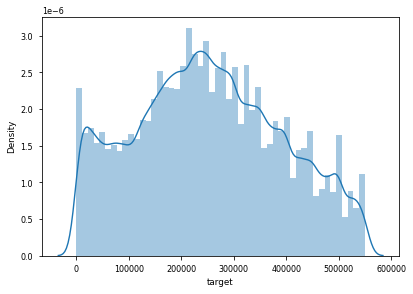

In [300]:
sns.distplot(data_d['target'])

{'bodies': [<matplotlib.collections.PolyCollection at 0x7f28864e7410>],
 'cmaxes': <matplotlib.collections.LineCollection at 0x7f288035cc90>,
 'cmins': <matplotlib.collections.LineCollection at 0x7f2880395b90>,
 'cbars': <matplotlib.collections.LineCollection at 0x7f2880395950>}

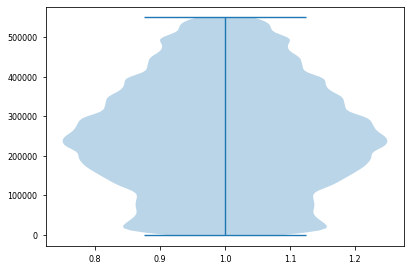

In [301]:
plt.violinplot(data_d['target'])

In [302]:
data_d['target'].isna().unique()

array([False])

In [303]:
data_d.loc[data_d['target']==0]

,status,private pool,propertyType,street,baths,homeFacts,fireplace,city,schools,sqft,zipcode,beds,state,stories,mls-id,PrivatePool,MlsId,target


In [304]:
data_d.loc[data_d['target'].min()]

status                                                   for sale
private pool                                                  NaN
propertyType                                   single-family home
street                                          12911 E Heroy Ave
baths                                                     3 Baths
homeFacts       {'atAGlanceFacts': [{'factValue': '2019', 'fac...
fireplace                                                     NaN
city                                               Spokane Valley
schools         [{'rating': ['4/10', 'None/10', '4/10'], 'data...
sqft                                                   1,947 sqft
zipcode                                                     99216
beds                                                       3 Beds
state                                                          WA
stories                                                       2.0
mls-id                                                        NaN
PrivatePoo

In [305]:
#data_d.target = np.log(data_d.target[data_d.target > 0])

In [306]:
#data_d['target'].isna().unique()

# Обработка признака homeFacts.

In [307]:
def facts_extraction(slovar):
    if slovar.find('atAGlanceFacts')>-1:
        slovar1 = eval(slovar)
       # print(type(slovar1))
        #print(slovar1)
        slovar2=slovar1.get('atAGlanceFacts')
       # print(type(slovar2))
       # print(slovar2)
        
        lst = ['']
        for i in slovar2:
            
            lst.append(i.get('factValue'))
        lst_res=lst[1:]
        return lst_res
            
    else: return np.NaN


In [308]:
data_d.homeFacts = data_d.homeFacts.apply(lambda x: facts_extraction(x))
t = data_d['homeFacts']
t_lst = t.tolist()
columns = ['Year built','Remodeled year','Heating','Cooling','Parking','lotsize','price_sqft']
t1 = pd.DataFrame(t_lst, columns = columns)
data_d = data_d.join(t1)

In [309]:
data_d.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 274467 entries, 0 to 377184
Data columns (total 25 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   status          245007 non-null  object 
 1   private pool    2712 non-null    object 
 2   propertyType    250827 non-null  object 
 3   street          274466 non-null  object 
 4   baths           192550 non-null  object 
 5   homeFacts       274467 non-null  object 
 6   fireplace       66993 non-null   object 
 7   city            274447 non-null  object 
 8   schools         274467 non-null  object 
 9   sqft            244803 non-null  object 
 10  zipcode         274467 non-null  object 
 11  beds            204895 non-null  object 
 12  state           274467 non-null  object 
 13  stories         167742 non-null  object 
 14  mls-id          19144 non-null   object 
 15  PrivatePool     22559 non-null   object 
 16  MlsId           224520 non-null  object 
 17  target    

# Разбор признака школы.

In [310]:
data_d.schools = data_d.schools.apply(lambda x: eval(x[1:-1]))
t = data_d['schools']
t_lst = t.tolist()
t5_lst = []
for i in t_lst:
    i1 = dict([('rating', i.get('rating')), ('Distance', (i.get('data')).get('Distance')), ('Grades', (i.get('data')).get('Grades')),('name',i.get('name'))])
    t5_lst.append(i1)

df_lst = pd.DataFrame(t5_lst,dtype=str)
data_d = data_d.join(df_lst)

In [311]:
data_d.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 274467 entries, 0 to 377184
Data columns (total 29 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   status          245007 non-null  object 
 1   private pool    2712 non-null    object 
 2   propertyType    250827 non-null  object 
 3   street          274466 non-null  object 
 4   baths           192550 non-null  object 
 5   homeFacts       274467 non-null  object 
 6   fireplace       66993 non-null   object 
 7   city            274447 non-null  object 
 8   schools         274467 non-null  object 
 9   sqft            244803 non-null  object 
 10  zipcode         274467 non-null  object 
 11  beds            204895 non-null  object 
 12  state           274467 non-null  object 
 13  stories         167742 non-null  object 
 14  mls-id          19144 non-null   object 
 15  PrivatePool     22559 non-null   object 
 16  MlsId           224520 non-null  object 
 17  target    

# Площадь

Вспомогательная функция для получения численного значения площади. Если значение некорректно, возвращает NaN.

In [312]:
def extract_num_recurr_sqft(stroka,first_digit,len_s,i):
    if i == len_s and stroka[i].isdigit():
        return (float(first_digit + str(stroka[i])))
    elif i < len_s and (stroka[i].isdigit() or stroka[i] == '.'):
        return extract_num_recurr_sqft(stroka, (first_digit + str(stroka[i])), len_s, i+1)
    elif i < len_s and stroka[i] == ',':
        return extract_num_recurr_sqft(stroka, first_digit, len_s, i+1)
    else: return(float(first_digit))
                        
def extract_num_sqft(stroka,len_s,i):
  
    if i == len_s and not stroka[i].isdigit():
        return np.NaN
    elif i == len_s and stroka[i].isdigit():
        return float(stroka[i])
    elif i < len_s and stroka[i].isdigit():
        return extract_num_recurr_sqft(stroka,str(stroka[i]),len_s,i+1)
    else: return extract_num_sqft(stroka,len_s,i+1)

def main_extract_num_sqft(stroka):   
    len_s=len(stroka)-1
    
    return extract_num_sqft(stroka,len_s,0)

In [313]:
data_d.sqft = data_d.sqft.apply(lambda x: main_extract_num_sqft(str(x)))

Вместо нулевых значений подставляю нан для упрощения последующей замены.

In [314]:
data_d.sqft = data_d.sqft.apply(lambda x: np.NaN if x==0.0 else x)

In [315]:
data_d.loc[data_d['sqft'].isna() == True]

,status,private pool,propertyType,street,baths,homeFacts,fireplace,city,schools,sqft,zipcode,beds,state,stories,mls-id,PrivatePool,MlsId,target,Year built,Remodeled year,Heating,Cooling,Parking,lotsize,price_sqft,rating,Distance,Grades,name
4,for sale,NaN,lot/land,1524 Kiscoe St,NaN,"[, , , , , 10,019 sqft, None]",NaN,Palm Bay,"{'rating': ['4/10', '5/10', '5/10'], 'data': {...",NaN,32908,NaN,FL,NaN,NaN,NaN,861745,5000.0,2006,2006,"Electric, Heat Pump",Central Air,,"4,996 Sq. Ft.",$120 / Sq. Ft.,"['3', '3', '1', 'NR']","['0.8 mi', '8.3 mi', '4.2 mi', '2.0 mi']","['Preschool to 4', 'Preschool to 12', '5 to 8'...","['Palmetto Elementary School', 'Haines City Se..."
7,Active,NaN,NaN,6094 Mingle Dr,NaN,"[1976, , , , , 8,750 Sq. Ft., $57 / Sq. Ft.]",NaN,Memphis,"{'rating': ['4', '2', '2'], 'data': {'Distance...",NaN,38115,NaN,TN,NaN,NaN,NaN,10063506,68000.0,2019,None,Gas,Central,Attached Garage,"2,056 sqft",$162,"['4/10', '3/10', '2/10']","['0.7 mi', '0.6 mi', '1.9 mi']","['PK-5', '5-8', '9-12']","['Edgewood Elementary School', 'Landrum Middle..."
40,Active,NaN,NaN,1104 Rotonda Cir,NaN,"[, , , , , —, None]",NaN,ROTONDA WEST,"{'rating': ['6', '6', '7'], 'data': {'Distance...",NaN,33947,NaN,FL,NaN,NaN,NaN,D6107075,54000.0,1974,,Electric,,,1.7 acres,$344/sqft,"['8/10', '6/10', '8/10']","['0.93mi', '0.59mi', '0.41mi']","['9-12', '6-8', 'PK-5']","['Dunwoody High School', 'Peachtree Middle Sch..."
48,Active,NaN,NaN,18b Sitton-Mills Pl,NaN,"[, , , , , —, None]",NaN,Signal Mountain,"{'rating': ['8', 'NR', '7', '4'], 'data': {'Di...",NaN,37377,NaN,TN,NaN,NaN,NaN,1310212,125000.0,1918,,Baseboard,,Off Street,"7,680 sqft",$617/sqft,"['6/10', '3/10', '4/10']","['0.33mi', '0.7mi', '0.18mi']","['6-8', 'PK-5', '9-12']","['Denny Middle School', 'Roxhill Elementary Sc..."
49,Active,NaN,Land,23443 N 65th Ave,NaN,"[, , , , , 50530, None]",NaN,Glendale,"{'rating': ['8', '9', '7', '8', '9', '7', 'NR'...",NaN,85310,NaN,AZ,NaN,NaN,NaN,5876037,275000.0,1960,1993,"Central, Electric",Central Air,,"10,200 Sq. Ft.",$190 / Sq. Ft.,"['4', '7', '7']","['1.4 mi', '2.6 mi', '4.8 mi']","['Preschool to 5', '6 to 8', '9 to 12']","['Peace River Elementary School', 'Port Charlo..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
377141,Active,NaN,NaN,Mantova Ct,NaN,"[, , , , , —, None]",NaN,ORLANDO,"{'rating': ['7', '6', 'NR', 'NR', '7'], 'data'...",NaN,32836,NaN,FL,NaN,NaN,NaN,O5763033,400000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
377146,for sale,NaN,single-family home,206/208 N Randolph St,NaN,"[1910, , , , , 5488 sqft, None]",NaN,Indianapolis,"{'rating': ['1/10'], 'data': {'Distance': ['0....",NaN,46201,NaN,IN,NaN,NaN,NaN,21686741,50000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
377154,Active,NaN,NaN,2104 Russell Ave,NaN,"[, , , , , 6,970 Sq. Ft., None]",NaN,Charlotte,"{'rating': ['2', '3', '3'], 'data': {'Distance...",NaN,28216,NaN,NC,NaN,NaN,NaN,3571015,99990.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
377161,Active,NaN,Land,Homestead Dr Lot 1,NaN,"[, , , , , 1, None]",NaN,Columbiana,"{'rating': ['8', '9', '8', 'NR'], 'data': {'Di...",NaN,44408,NaN,OH,NaN,NaN,NaN,3382834,45000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [316]:
data_d[['sqft']] = data_d[['sqft']].fillna(data_d['sqft'].median())

In [317]:
data_d['sqft'].isna().sum()

0

In [318]:
data_d.loc[data_d['sqft'].min()]

status                                                     for sale
private pool                                                    NaN
propertyType                                     single-family home
street                                            12911 E Heroy Ave
baths                                                       3 Baths
homeFacts                      [2019, , , , , 5828 sqft, $159/sqft]
fireplace                                                       NaN
city                                                 Spokane Valley
schools           {'rating': ['4/10', 'None/10', '4/10'], 'data'...
sqft                                                         1947.0
zipcode                                                       99216
beds                                                         3 Beds
state                                                            WA
stories                                                         2.0
mls-id                                          

<AxesSubplot:xlabel='sqft', ylabel='Density'>

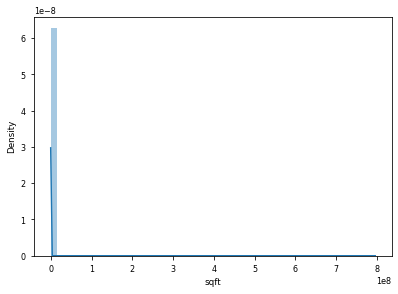

In [319]:
sns.distplot(data_d['sqft'])

In [320]:
data_d.loc[data_d['sqft'].median()]

status                                                     for sale
private pool                                                    NaN
propertyType                                                  condo
street                                        2924 Collins Ave #503
baths                                                       2 Baths
homeFacts            [1980, 1980, Electric, Central, , , $487/sqft]
fireplace                                                       NaN
city                                                    Miami Beach
schools           {'rating': ['5/10', '10/10', '4/10', '10/10', ...
sqft                                                         1077.0
zipcode                                                       33140
beds                                                         2 Beds
state                                                            FL
stories                                                         NaN
mls-id                                          

In [321]:
data_d['sqft_big'] = data_d['sqft'].apply(lambda x: 1 if x > 2300 else 0)

In [322]:
data_d.sqft = data_d.sqft.apply(lambda x: 2301 if x>2300 else x)

# Визуализация признака площадь

<AxesSubplot:xlabel='sqft', ylabel='Density'>

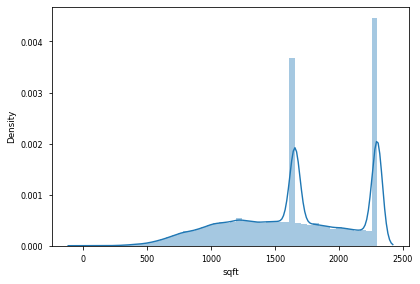

In [323]:
sns.distplot(data_d['sqft'])


Text(0.5, 1.0, 'Зависимость цены от площади')

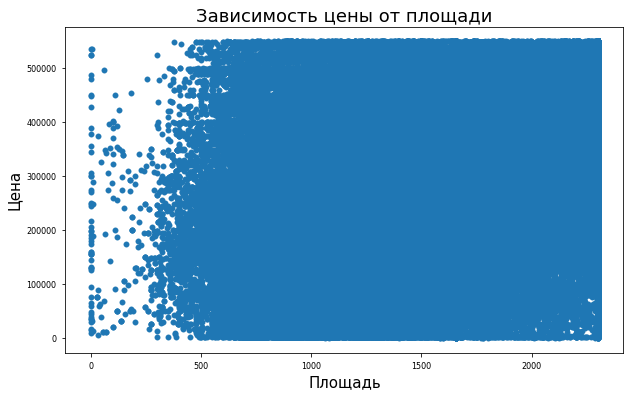

In [324]:
x = data_d['sqft']
y = data_d['target']
plt.figure(figsize = (10,6))
plt.scatter(x, y)


# добавим подписи
plt.xlabel('Площадь', fontsize = 15)
plt.ylabel('Цена', fontsize = 15)
plt.title('Зависимость цены от площади', fontsize = 18)

<AxesSubplot:xlabel='sqft'>

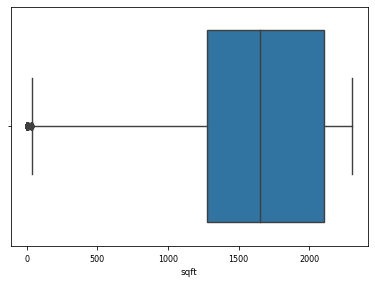

In [325]:
sns.boxplot(data_d['sqft'])

# Спальни - приведение к численному виду.

In [326]:
data_d.loc[data_d['beds'] == '# Bedrooms 1st Floor']

,status,private pool,propertyType,street,baths,homeFacts,fireplace,city,schools,sqft,zipcode,beds,state,stories,mls-id,PrivatePool,MlsId,target,Year built,Remodeled year,Heating,Cooling,Parking,lotsize,price_sqft,rating,Distance,Grades,name,sqft_big
364340,A Active,NaN,Land,4500 Harris Hill Rd,NaN,"[1922, , , , , 1079000, None]",NaN,Falconer,"{'rating': ['5', '5', 'NR', 'NR', 'NR'], 'data...",1596.0,14733,# Bedrooms 1st Floor,NY,NaN,NaN,NaN,R1171774,79000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0


In [327]:
data_d = data_d.drop(np.where(data_d['beds'] == '# Bedrooms 1st Floor'))

ValueError: Index data must be 1-dimensional

Вспомогательная функция stirng_part со вложенной string_part_extract для выделения символьной части.

In [ ]:
def string_part_extract(string, len_s, i, res_str):
    if i<len_s:
      
        if string[i].isdigit(): return string_part_extract(string, len_s, i+1, res_str)
        else:
    
            return string_part_extract(string, len_s, i+1, res_str+string[i])
    elif i==len_s:
    
        if string[i].isdigit(): 
           
            return res_str
        
        else:
       
            return (res_str+string[i])
    
    
    
    
def stirng_part(string):
    len_s = len(str(string))-1
    pus = ""
    return string_part_extract(str(string), len_s, 0, pus)

Вспомогательная функция, проверяет определенные слова в описании признака.

In [ ]:
def subsrting_beds(source_string):
    list_of_strings = ['Bd','Bedrooms','Beds','Bed','bd','beds','bed','bedrooms']
    for substring in list_of_strings:
        if substring in source_string:
            return False
    return True

Предварительная обработка признака для систематизации словесных комментариев. (Для того, чтобы значимые величины не попали в выбросы.)

In [ ]:
#data_d = data_d.drop(np.where(data_d['beds'] == '# Bedrooms 1st Floor'))
data_d.beds = data_d.beds.apply(lambda x: 1 if subsrting_beds(stirng_part(x)) else x)
data_d.beds = data_d.beds.apply(lambda x: 1 if 'Bath' in str(x) else x)
data_d.beds = data_d.beds.apply(lambda x: 1 if x == '1-2 Beds' or x == '-- bd' else x)
data_d.beds = data_d.beds.apply(lambda x: 1 if x == '1-2 Beds' or x == '-- bd' else x)
data_d.beds = data_d.beds.apply(lambda x: 1 if (str(x).find('sqft')>-1) else x)
data_d.beds = data_d.beds.apply(lambda x: 1 if (str(x).find('acres')>-1) else x)
data_d.beds = data_d.beds.apply(lambda x: 1 if (str(x).find('# Bedrooms 1st Floor')>-1) else x)
data_d['beds'].unique()                        
data_d['beds'].value_counts() 

In [ ]:
data_d.loc[data_d['beds'] == '# Bedrooms 1st Floor']

Вспомогательная функция для выбора числового значения признака спальни.

In [ ]:
def otbor(stroka,i):
    if i == len(stroka): return(int(stroka))
    elif stroka[i] == ' ':
            return (int(stroka[:i]))
    else: return otbor(stroka,i+1)
    

In [ ]:
data_d.beds = data_d.beds.apply(lambda x: otbor(str(x),0))

In [ ]:
data_d['beds'].unique()                        


In [ ]:
data_d['beds'].isna().sum()

# Визуализация и обработка признака спальни (beds).

In [ ]:
data_d['beds_big']= data_d['beds'].apply(lambda x: 1 if x>7 else 0)

In [ ]:
data_d.beds = data_d.beds.apply(lambda x: 11 if x>10 else x)

In [ ]:
sns.distplot(data_d['beds'])

In [ ]:
y = data_d['target']

In [ ]:
x = data_d['beds']

In [ ]:
plt.figure(figsize = (10,6))
plt.scatter(x, y)


# добавим подписи
plt.xlabel('Количество комнат', fontsize = 15)
plt.ylabel('Цена', fontsize = 15)
plt.title('Зависимость цены от количества комнат', fontsize = 18)


In [ ]:
sns.boxplot(data_d['beds'])

# Ванны - приведение к численному виду.

Вспомогательная функция извлекает численное значение из текста. Если значение некорректно, выдает 1. Применила здесь, а также для обработки этажей.)

In [ ]:
def extract_num_recurr(stroka,first_digit,len_s,i):
    if i == len_s and stroka[i].isdigit():
        return (float(first_digit + str(stroka[i])))
    elif i < len_s and (stroka[i].isdigit() or stroka[i] == '.'):
        return extract_num_recurr(stroka, (first_digit + str(stroka[i])), len_s, i+1)
    
    else: return(float(first_digit))
                        
def extract_num(stroka,len_s,i):
  
    if i == len_s and not stroka[i].isdigit():
        return 1
    elif i == len_s and stroka[i].isdigit():
        return float(stroka[i])
    elif i < len_s and stroka[i].isdigit():
        return extract_num_recurr(stroka,str(stroka[i]),len_s,i+1)
    else: return extract_num(stroka,len_s,i+1)

def main_extract_num(stroka):   
    len_s=len(stroka)-1
    
    return extract_num(stroka,len_s,0)

In [ ]:
data_d.baths = data_d.baths.apply(lambda x: round(main_extract_num(str(x)),1))

In [ ]:
data_d['baths'].unique()   

In [ ]:
data_d['baths'].isna().sum()

# Визуализация и обработка признака ванны (baths).

In [ ]:
sns.distplot(data_d['baths'])

In [ ]:
data_d.loc[data_d['baths']>10]

In [ ]:
data_d = data_d[data_d['baths']<10]

In [ ]:
sns.distplot(data_d['baths'])

In [ ]:
x = data_d['baths']
y = data_d['target']

In [ ]:
plt.figure(figsize = (10,6))
plt.scatter(x, y)


# добавим подписи
plt.xlabel('Цена', fontsize = 15)
plt.ylabel('Оборудование ванн', fontsize = 15)
plt.title('Зависимость цены от оборудования ванн', fontsize = 18)

 # Камин

Вспомогательная функция для приведения признака числа каминов к численному виду.

In [ ]:
def fireplaces_def(stroka):
    if stroka == 'yes': return 1
    elif stroka == 'Yes': return 1
    elif stroka == '1': return 1
    elif stroka == '2': return 2
    else: return 0

In [ ]:
data_d.fireplace = data_d.fireplace.apply(lambda x: fireplaces_def(str(x)))


In [ ]:
data_d['fireplace'].unique()

In [ ]:
data_d['fireplace'].isna().sum() 

In [ ]:
x = data_d['fireplace']
y = data_d['target']

In [ ]:
plt.figure(figsize = (10,6))
plt.scatter(x, y)


# добавим подписи
plt.xlabel('Цена', fontsize = 15)
plt.ylabel('Камин', fontsize = 15)
plt.title('Зависимость цены от наличия камина', fontsize = 18)

# Бассейн. Анализ.

In [ ]:
data_d['private pool'].value_counts()

In [ ]:
data_d.loc[data_d['private pool'] == 'Yes']

Вывод: число домов с бассейнами незначительно (4181 из 377185), разброс цен для домов с бассейнами большой, явного влияния на цену нет. Можно не рассматривать.

 # propertyType

In [ ]:
data_d['propertyType'].value_counts(normalize=True)

In [ ]:
data_d.propertyType = data_d.propertyType.apply(lambda x: str(x))

In [ ]:
data_d.propertyType = data_d.propertyType.apply(lambda x: 'sfh' if x in ['single-family home','Single Family','Single Family Home'] else x)

In [ ]:
data_d.propertyType = data_d.propertyType.apply(lambda x: x.lower())

In [ ]:
data_d.propertyType = data_d.propertyType.apply(lambda x: 'mlf' if (x.find('multi')>-1) else x)
data_d.propertyType = data_d.propertyType.apply(lambda x: 'ctmp' if (x.find('contempor')>-1) else x)
data_d.propertyType = data_d.propertyType.apply(lambda x: 'loft' if (x.find('loft')>-1) else x)
data_d.propertyType = data_d.propertyType.apply(lambda x: 'twnh' if (x.find('townhouse')>-1) else x)
data_d.propertyType = data_d.propertyType.apply(lambda x: 'condo' if (x.find('condo')>-1) else x)
data_d.propertyType = data_d.propertyType.apply(lambda x: 'sn_dtch' if (x.find('single detached')>-1) else x)
data_d.propertyType = data_d.propertyType.apply(lambda x: 'eng' if (x.find('english')>-1) else x)
data_d.propertyType = data_d.propertyType.apply(lambda x: 'other' if x not in ['mlf','ctmp','loft','twnh','condo','sn_dtch','eng'] else x)

In [ ]:
data_d['propertyType'].value_counts()

Преобразование к численному виду.

In [390]:
data_d['propertyType'] = data_d['propertyType'].astype('category')
data_d['propertyType_cat'] = data_d['propertyType'].cat.codes
data_d['propertyType_cat'] = data_d['propertyType_cat'].astype('category')

In [ ]:
data_d['propertyType'].isna().sum() 

In [ ]:
x = data_d['propertyType_cat']
y = data_d['target']

In [ ]:
plt.figure(figsize = (10,6))
plt.scatter(x, y)


# добавим подписи
plt.xlabel('Цена', fontsize = 15)
plt.ylabel('Тим собственности', fontsize = 15)
plt.title('Зависимость цены от типа собственности', fontsize = 18)

# Город

In [ ]:
data_d.city.fillna('others',inplace=True)

In [ ]:
data_d['city'].isna().sum()

In [ ]:
t = data_d['city'].value_counts()

In [ ]:
t_df = pd.DataFrame(t)

In [ ]:
t_df.loc[t_df['city']==np.NaN]

In [ ]:
t_df['city'].isna().sum()

In [ ]:
dict_t = t_df.to_dict()

In [ ]:
dict_city = dict_t.get('city')

In [ ]:
data_d['city'].isna().sum()

Вспомогательная функция присваивает значение others, если число вхождений данного города невелико. (Здесь меньше 500.)

In [ ]:
def other_cities(x1,d):
    if x1==np.NaN:
        return ('others')
    elif d.get(x1)==np.NaN:
        return('others')
    elif d.get(x1)<500: return ('others')
    else: return(x1)


In [ ]:
data_d.city = data_d.city.apply(lambda x: other_cities(x,dict_city))

In [ ]:
data_d.loc[data_d['city']=='others']

In [ ]:
#from sklearn.preprocessing import OneHotEncoder
#ohe = OneHotEncoder(sparse=False)

In [ ]:
#ohe_ftrs = ohe.fit_transform(data_d['city'].values.reshape(-1,1))

In [ ]:
#tmp = pd.DataFrame(ohe_ftrs, columns = ['city=' + str(i) for i in range(ohe_ftrs.shape[1])])
#data_d = pd.concat([data_d, tmp], axis=1)


In [ ]:
#data_d['city=97'].isna().sum()

In [ ]:
data_d['city'] = data_d['city'].astype('category')
data_d['city_cat'] = data_d['city'].cat.codes

In [ ]:
sns.distplot(data_d['city_cat'])

In [ ]:
data_d['city_cat'].isna().sum()

In [ ]:
x = data_d['city_cat']
y = data_d['target']

In [ ]:
plt.figure(figsize = (10,6))
plt.scatter(x, y)


# добавим подписи
plt.xlabel('Цена', fontsize = 15)
plt.ylabel('Город', fontsize = 15)
plt.title('Зависимость цены от города', fontsize = 18)

# Штат

In [ ]:
data_d['state'] = data_d['state'].astype('category')
data_d['state_cat'] = data_d['state'].cat.codes

In [ ]:
data_d['state_cat'].isna().sum()

In [ ]:
x = data_d['state_cat']
y = data_d['target']

In [ ]:
plt.figure(figsize = (10,6))
plt.scatter(x, y)


# добавим подписи
plt.xlabel('Площадь', fontsize = 15)
plt.ylabel('Штат', fontsize = 15)
plt.title('Зависимость цены от штата', fontsize = 18)

# Улица

In [ ]:
data_d['street'].nunique()

Уникальных значений улиц слишком много. Признак удалила.

 # Stories (надеюсь, это этажи)

In [ ]:
data_d.stories = data_d.stories.apply(lambda x: main_extract_num(str(x)))


In [ ]:
data_d['stories'].isna().sum()

In [ ]:
sns.distplot(data_d['stories'])

In [ ]:
data_d.loc[data_d['stories']>17]

In [ ]:
data_d = data_d[data_d['stories']<17]

In [ ]:
x = data_d['stories']
y = data_d['target']

In [ ]:
plt.figure(figsize = (10,6))
plt.scatter(x, y)


# добавим подписи
plt.xlabel('Цена', fontsize = 15)
plt.ylabel('Этаж', fontsize = 15)
plt.title('Зависимость цены от этажа', fontsize = 18)

 # Status

In [ ]:
data_d['status'].value_counts()

In [ ]:
data_d.status = data_d.status.apply(lambda x: 'for_sale' if x in ['for sale','For sale'] else x)

In [ ]:
data_d.status = data_d.status.apply(lambda x: str(x))

In [ ]:
data_d.status = data_d.status.apply(lambda x: x.lower())

In [ ]:
data_d.status = data_d.status.apply(lambda x: 'actv' if (x.find('activ')>-1) else x)
data_d.status = data_d.status.apply(lambda x: 'cnstr' if (x.find('construction')>-1) else x)
data_d.status = data_d.status.apply(lambda x: 'cntrct' if (x.find('contract')>-1) else x)
data_d.status = data_d.status.apply(lambda x: 'frcls' if (x.find('foreclosure')>-1) else x)
data_d.status = data_d.status.apply(lambda x: 'pnd' if (x.find('pending')>-1) else x)
data_d.status = data_d.status.apply(lambda x: 'cntgs' if (x.find('contingen')>-1) else x)
data_d.status = data_d.status.apply(lambda x: 'cmg_s' if (x.find('coming soon')>-1) else x)
data_d.status = data_d.status.apply(lambda x: 'frcls' if (x.find('foreclosure')>-1) else x)

In [ ]:
data_d['status'].value_counts()

Приведение к численному виду.

In [ ]:
data_d['status'] = data_d['status'].astype('category')
data_d['status_cat'] = data_d['status'].cat.codes

In [ ]:
data_d['status'].isna().sum()

In [ ]:
x = data_d['status_cat']
y = data_d['target']


In [ ]:
plt.figure(figsize = (10,6))
plt.scatter(x, y)


# добавим подписи
plt.xlabel('Площадь', fontsize = 15)
plt.ylabel('Статус продажи', fontsize = 15)
plt.title('Зависимость цены от статуса продажи', fontsize = 18)

# Индекс

In [ ]:
data_d['zipcode'].value_counts()

In [ ]:
data_d.zipcode = data_d.zipcode.apply(lambda x: (str(x))[0:2])

In [ ]:
data_d.loc[data_d['zipcode']=='--']

In [ ]:
data_d['zipcode'].value_counts()

In [ ]:
data_d = data_d.drop(data_d[data_d['zipcode']=='--'].index)
data_d = data_d.drop(data_d[data_d['zipcode']=='0'].index)
#data_d = data_d.drop(data_d[data_d['zipcode']=='--'].index)

In [ ]:
data_d.zipcode = data_d.zipcode.apply(lambda x: int(x))

In [ ]:
data_d['zipcode'].value_counts()

In [ ]:
data_d['zipcode'].isna().sum()

In [ ]:
data_d['zipcode'] = data_d['zipcode'].astype('category')

In [ ]:
x = data_d['zipcode']
y = data_d['target']

In [ ]:
plt.figure(figsize = (10,6))
plt.scatter(x, y)


# добавим подписи
plt.xlabel('Цена', fontsize = 15)
plt.ylabel('Индекс', fontsize = 15)
plt.title('Зависимость цены от индекса', fontsize = 18)

# Обработка признака homeFacts.

Вспомогательная функция для извлечения списка значимых величин из признака. (Извлекает список словарей из исходной структуры, которая тоже является словарем. Затем по ключевым словам словаря формирует список значимых величин. Возвращает нан, если в списке отсутствует ключевое слово основного словаря.)

In [ ]:
#def facts_extraction(slovar):
#    if slovar.find('atAGlanceFacts')>-1:
#        slovar1 = eval(slovar)
#       # print(type(slovar1))
#        #print(slovar1)
#        slovar2=slovar1.get('atAGlanceFacts')
#       # print(type(slovar2))
#       # print(slovar2)
#        
#        lst = ['']
#        for i in slovar2:
#            
#            lst.append(i.get('factValue'))
#        lst_res=lst[1:]
#        return lst_res
#            
#    else: return np.NaN

In [ ]:
#data_d.homeFacts = data_d.homeFacts.apply(lambda x: facts_extraction(x))

In [ ]:
#t = data_d['homeFacts']
#t

In [ ]:
#t_lst = t.tolist()

In [ ]:
#columns = ['Year built','Remodeled year','Heating','Cooling','Parking','lotsize','price_sqft']

In [ ]:
#t1 = pd.DataFrame(t_lst, columns = columns)

In [ ]:
#data_d = data_d.join(t1)

In [ ]:
#data_d.head(3)

In [ ]:
#data_d['price_sqft'].unique()

# Обработка признака школы

In [ ]:
#data_d.schools = data_d.schools.apply(lambda x: eval(x[1:-1]))

In [ ]:
#t = data_d['schools']
#t

In [ ]:
#t_lst = t.tolist()

In [ ]:
#t5_lst = []
#for i in t_lst:
#    i1 = dict([('rating', i.get('rating')), ('Distance', (i.get('data')).get('Distance')), ('Grades', (i.get('data')).get('Grades')),('name',i.get('name'))])
#    t5_lst.append(i1)

In [ ]:
#df_lst = pd.DataFrame(t5_lst,dtype=str)

In [ ]:
#df_lst.head(10)

In [ ]:
#data_d = data_d.join(df_lst)

# Разбор нового признака - рейтинг школы

Вспомогательная функция - возвращает численный список: численное значение рейтинга, если рейтинг выражен числом, первое значение дроби или ноль, если встречаются любые другие символы.

In [ ]:
data_d['typeRating']=data_d['rating'].apply(lambda x: type(x))

In [ ]:
data_d['typeRating'].value_counts()

In [ ]:
data_d.rating=data_d.rating.apply(lambda x: '[]' if type(x)==float else x)

In [ ]:
data_d.head(4)

In [ ]:
data_d.rating=data_d.rating.apply(lambda x: eval(x))

In [ ]:
def school_rating1 (lst_r):
    lst_clean = []
    for p in lst_r:
        if p.find('/') == -1:
            if p.isdigit():
                lst_clean.append(int(p))
            else: lst_clean.append(0)
        else:
            num = p[:p.find('/')]
            if num.isdigit():
                lst_clean.append(int(num))
                
            else: lst_clean.append(0)

    return lst_clean

In [ ]:
data_d.rating = data_d.rating.apply(lambda x: school_rating1(x))

In [ ]:
data_d.head(2)

# Создание новых признаков: маскимальный рейтинг, средний рейтинг.

In [ ]:
data_d['max_rating'] = data_d['rating'].apply(lambda x: 0 if x == [] else max(x))

In [ ]:
data_d['mean_rating'] = data_d['rating'].apply(lambda x: 0 if x == [] else round(sum(x)/len(x),2))

In [ ]:
data_d.head(3)

# Разбор нового признака расстояние

Вспомогательная функция возвращает список числовых значений расстояния

In [ ]:
data_d.Distance=data_d.Distance.apply(lambda x: '[]' if type(x)==float else x)

In [ ]:
data_d['type_Dist'] = data_d['Distance'].apply(lambda x: type(x))

In [ ]:
data_d['type_Dist'].value_counts()

In [ ]:
data_d.Distance = data_d.Distance.apply(lambda x: eval(x))

In [ ]:
data_d['type_Dist'] = data_d['Distance'].apply(lambda x: type(x))

In [ ]:
data_d.head(4)

In [ ]:
data_d['typeRating'].value_counts()

In [ ]:
def distance_select(distance):
    lst_dist = []
    if distance == []: return []
    else:
        for i in distance:
            if i.find(' mi')>-1:
                lst_dist.append(float(i[:-3]))
            elif i.find('mi')>-1:
                lst_dist.append(float(i[:-2]))
            else: lst_dist.append(0)
    return lst_dist

In [ ]:
data_d.Distance = data_d.Distance.apply(lambda x: distance_select(x))

In [ ]:
data_d.head(4)

# Добавление новых признаков: минимальное расстояние до школы, среднее расстояние до школы.

In [ ]:
data_d['min_distance'] = data_d['Distance'].apply(lambda x: 0 if x == [] else min(x))
data_d['mean_distance'] = data_d['Distance'].apply(lambda x: 0 if x == [] else round(sum(x)/len(x),2))

# Выделение нового признака - цена за квадратный метр.

In [ ]:
data_d['price_sqft'].isna().sum()

In [ ]:
def price_clean(price):
    
    if price == None: return np.NaN
    
    elif type(price) == float: return price

    elif price.find('$')>-1: return price_clean(price[1:])
   
    elif price.find('/')>-1: return price_clean(price[0:price.find('/')])
    
    elif price.isnumeric(): return float(price)
    
    else: return np.NaN

In [ ]:
data_d.price_sqft = data_d.price_sqft.apply(lambda x: price_clean(x))

In [ ]:
data_d['price_sqft'].isna().sum()

# Для модели, построенной для цены за квадратный метр, заполнение убрать.

In [ ]:
data_d[['price_sqft']] = data_d[['price_sqft']].fillna(data_d['price_sqft'].median())

In [ ]:
data_d['price_sqft'].isna().sum()

# Выбор предварительного датафрейма для модели

In [392]:
columns = data_d.columns

In [393]:
columns = columns.tolist()

In [337]:
columns

['status',
 'private pool',
 'propertyType',
 'street',
 'baths',
 'homeFacts',
 'fireplace',
 'city',
 'schools',
 'sqft',
 'zipcode',
 'beds',
 'state',
 'stories',
 'mls-id',
 'PrivatePool',
 'MlsId',
 'target',
 'Year built',
 'Remodeled year',
 'Heating',
 'Cooling',
 'Parking',
 'lotsize',
 'price_sqft',
 'rating',
 'Distance',
 'Grades',
 'name',
 'sqft_big']

In [ ]:
#lst_remove = ['status','mls-id','private pool',
# 'PrivatePool','Year built','state',
# 'Remodeled year',
# 'Heating',
# 'Cooling',
# 'Parking',
# 'lotsize',
# 'MlsId','propertyType','street','homeFacts','city','schools','rating',
# 'Distance',
# 'Grades',
# 'name','typeRating',
# 'mean_rating']

In [396]:
lst_remove = ['status','mls-id','private pool',
 'PrivatePool','Year built','state',
 'Remodeled year',
 'Heating',
 'Cooling',
 'Parking',
 'lotsize',
 'MlsId','propertyType','street','homeFacts','city','schools','rating',
 'Distance',
 'Grades',
 'name','typeRating',
 'type_Dist']

In [397]:
columns = columns
lst_remove = lst_remove
for i in lst_remove:
    columns.remove(i)

ValueError: list.remove(x): x not in list

In [ ]:
#columns.remove('type_Dist')
#columns.remove('zipcode')
#columns.remove('sqft_big')
#columns.remove('beds_big')

In [334]:
columns

['Year built',
 'Remodeled year',
 'Heating',
 'Cooling',
 'Parking',
 'lotsize',
 'price_sqft']

In [333]:
columns.remove('baths')
columns.remove('fireplace')
columns.remove('beds')

ValueError: list.remove(x): x not in list

In [ ]:
data_d_preliminary=data_d[columns]

In [340]:
data_d_preliminary.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 274184 entries, 0 to 377184
Data columns (total 16 columns):
 #   Column         Non-Null Count   Dtype   
---  ------         --------------   -----   
 0   baths          274184 non-null  object  
 1   fireplace      274184 non-null  object  
 2   sqft           274184 non-null  float64 
 3   zipcode        274184 non-null  category
 4   beds           274184 non-null  object  
 5   stories        274184 non-null  float64 
 6   target         274184 non-null  float64 
 7   price_sqft     274184 non-null  float64 
 8   sqft_big       274184 non-null  int64   
 9   city_cat       274184 non-null  int16   
 10  state_cat      274184 non-null  int8    
 11  status_cat     274184 non-null  int8    
 12  max_rating     274184 non-null  int64   
 13  mean_rating    274184 non-null  float64 
 14  min_distance   274184 non-null  float64 
 15  mean_distance  274184 non-null  float64 
dtypes: category(1), float64(7), int16(1), int64(2), int8(2),

In [341]:
columns = data_d_preliminary.columns
columns = columns.tolist()
columns.remove('baths')

In [346]:
columns = columns.tolist()

In [347]:
columns.remove('baths')
columns.remove('fireplace')
columns.remove('beds')

In [348]:
data_d_preliminary=data_d_preliminary[columns]

In [391]:
data_d_preliminary.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 274184 entries, 0 to 377184
Data columns (total 13 columns):
 #   Column         Non-Null Count   Dtype   
---  ------         --------------   -----   
 0   sqft           274184 non-null  float64 
 1   zipcode        274184 non-null  category
 2   stories        274184 non-null  float64 
 3   target         274184 non-null  float64 
 4   price_sqft     274184 non-null  float64 
 5   sqft_big       274184 non-null  int64   
 6   city_cat       274184 non-null  int16   
 7   state_cat      274184 non-null  int8    
 8   status_cat     274184 non-null  int8    
 9   max_rating     274184 non-null  int64   
 10  mean_rating    274184 non-null  float64 
 11  min_distance   274184 non-null  float64 
 12  mean_distance  274184 non-null  float64 
dtypes: category(1), float64(7), int16(1), int64(2), int8(2)
memory usage: 30.3 MB


In [350]:
data_d_preliminary.isna().sum()

sqft             0
zipcode          0
stories          0
target           0
price_sqft       0
sqft_big         0
city_cat         0
state_cat        0
status_cat       0
max_rating       0
mean_rating      0
min_distance     0
mean_distance    0
dtype: int64

In [ ]:
#data_d_preliminary['propertyType_cat'].fillna(method = 'ffill', inplace = True)
data_d_preliminary['baths'].fillna(method = 'ffill', inplace = True)
data_d_preliminary['beds'].fillna(method = 'ffill', inplace = True)
#data_d_preliminary['stories'].fillna(method = 'ffill', inplace = True)
data_d_preliminary['fireplace'].fillna(method = 'ffill', inplace = True)
#data_d_preliminary['sqft'].fillna(method = 'ffill', inplace = True)

In [ ]:
#data_d_preliminary['fireplace'].fillna(method = 'ffill', inplace = True)
#data_d_preliminary['sqft'].fillna(method = 'ffill', inplace = True)

In [264]:
data_d_preliminary.isna().sum()

baths            0
fireplace        0
sqft             0
zipcode          0
beds             0
stories          0
target           0
price_sqft       0
sqft_big         0
city_cat         0
state_cat        0
status_cat       0
max_rating       0
mean_rating      0
min_distance     0
mean_distance    0
dtype: int64

# Визуализация

(12.5, -0.5)

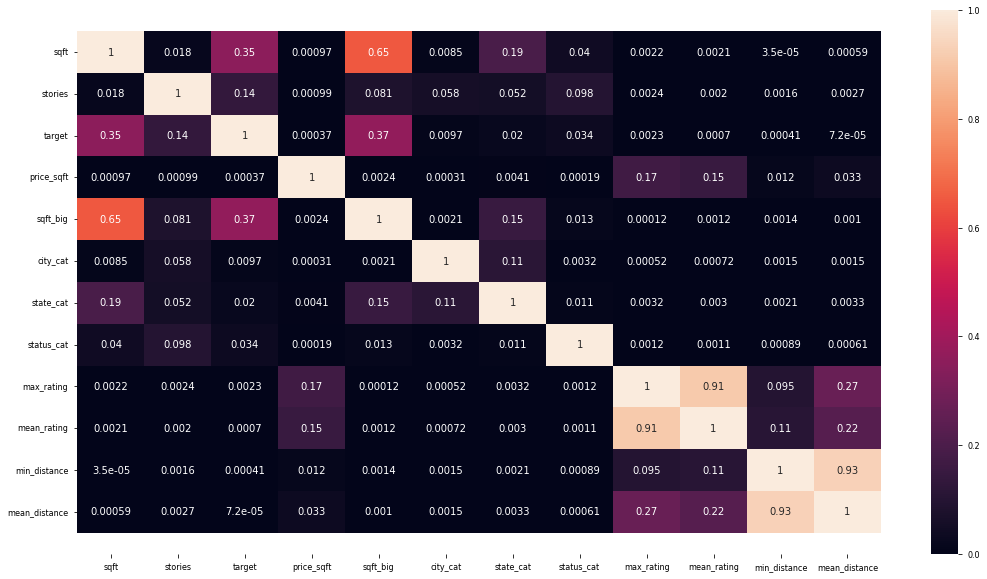

In [265]:
plt.figure(figsize=(18, 10))
ax = sns.heatmap(data_d_preliminary.corr().abs(), vmin=0, vmax=1, annot = True)
i, k = ax.get_ylim()
ax.set_ylim(i+0.5, k-0.5)

In [ ]:

#data_d_preliminary['state_cat'] = data_d_preliminary[(data_d_preliminary['state_cat'] < 500 ) | (data_d_preliminary['sity_state_cat'] > 1700)]['sity_state_cat']
#sns.boxplot(data_d_preliminary['sity_state_cat'])

377185

In [ ]:
#data_d_preliminary.isna().sum()

In [ ]:
#values = {'propertyType_cat':1275}
#data_d_preliminary = data_d_preliminary.fillna(value=values)

In [ ]:
#data_d_preliminary = data_d_preliminary.dropna()

In [ ]:
#data_d_preliminary.isnull().sum()

# Нормализация

In [ ]:
# min_maz_Scaler=preprocessing.MinMaxScaler()

In [ ]:
# col=data_d_preliminary.columns
# result=min_maz_Scaler.fit_transform(data_d_preliminary)
# data_d_preliminaty_n=pd.DataFrame(result,columns=col)

In [ ]:
# data_d_preliminaty_n

In [ ]:
#plt.figure(figsize=(18, 10))
#ax = sns.heatmap(data_d_preliminaty_n.corr().abs(), vmin=0, vmax=1, annot = True)
#i, k = ax.get_ylim()
#ax.set_ylim(i+0.5, k-0.5)

> # Грубая модель

In [ ]:
data_d_preliminary.isna().sum()

In [ ]:
#data_d_preliminary['propertyType_cat'].fillna(method = 'ffill', inplace = True)
#data_d_preliminary['baths'].fillna(method = 'ffill', inplace = True)
#data_d_preliminary['beds'].fillna(method = 'ffill', inplace = True)
#data_d_preliminary['stories'].fillna(method = 'ffill', inplace = True)


In [ ]:
# data_d_preliminary=data_d_preliminary.dropna()

In [351]:
columns = data_d_preliminary.columns
columns = columns.tolist()


In [352]:
columns.remove('target')


In [353]:
X=data_d_preliminary[columns]

In [354]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 274184 entries, 0 to 377184
Data columns (total 12 columns):
 #   Column         Non-Null Count   Dtype   
---  ------         --------------   -----   
 0   sqft           274184 non-null  float64 
 1   zipcode        274184 non-null  category
 2   stories        274184 non-null  float64 
 3   price_sqft     274184 non-null  float64 
 4   sqft_big       274184 non-null  int64   
 5   city_cat       274184 non-null  int16   
 6   state_cat      274184 non-null  int8    
 7   status_cat     274184 non-null  int8    
 8   max_rating     274184 non-null  int64   
 9   mean_rating    274184 non-null  float64 
 10  min_distance   274184 non-null  float64 
 11  mean_distance  274184 non-null  float64 
dtypes: category(1), float64(6), int16(1), int64(2), int8(2)
memory usage: 28.2 MB


In [355]:
X.isna().sum()

sqft             0
zipcode          0
stories          0
price_sqft       0
sqft_big         0
city_cat         0
state_cat        0
status_cat       0
max_rating       0
mean_rating      0
min_distance     0
mean_distance    0
dtype: int64

In [ ]:
#X_tes = data_d_test[['sqft']]
#y_tes = data_d_test[['target']]

In [ ]:
#X_tes

In [356]:

y = data_d_preliminary[['target']]
#y.target.fillna(500000)

#X1 = data_d_preliminary[['sity_state_cat','baths','beds']]

In [ ]:
#y.target.fillna(50000,inplace=True)

In [330]:
y.isna().sum()

target    0
dtype: int64

In [357]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    train_size=0.67, 
                                                    random_state=RANDOM_SEED)

# Тестирование моделей

# Линейная регрессия

In [358]:
from sklearn import metrics

model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print('Root Mean Squared Error (RMSE):', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print('R2:', np.round(metrics.r2_score(y_test, y_pred), 2))

Root Mean Squared Error (RMSE): 125337.7825350639
R2: 0.19


# Случайный лес

In [359]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import roc_auc_score

model =  RandomForestRegressor(n_estimators=10 ,
                               oob_score=True,
                               random_state=RANDOM_SEED)
model.fit(X_train, y_train) # обучение
a = model.predict(X_test) # предсказание
a

score = model.score(X_train, y_train)
print("R-squared:", score) 
#print ("AUC-ROC (oob) = ", roc_auc_score(y_train, model.oob_prediction_))
#print ("AUC-ROC (test) = ", roc_auc_score(y_test, a))

R-squared: 0.8870406388230216


# Регрессия с дополнительными деревьями

In [360]:
extra_tree = ExtraTreesRegressor(n_estimators = 400, 
                                 n_jobs=-1, random_state=RANDOM_SEED)
extra_tree.fit(X_train, y_train)
predict_extra_tree = extra_tree.predict(X_test)
predict_extra_tree

np.array(y_test.index.values)
print(np.array(y_test.index.values))
# оцениваем точность
print(mape(np.array(y_test.index.values), predict_extra_tree))
#print((mape_log(y_test, predict_extra_tree)))
#pprint(f"MAPE: {(mape_log(y_test, predict_extra_tree))*100:0.2f}%")


[245786  72508  63607 ... 303695 280592 216215]
7.031857963679347


In [361]:
print(np.array(y_test.index.values))

[245786  72508  63607 ... 303695 280592 216215]


In [362]:
print(mape(np.array(y_test.index.values), predict_extra_tree))

7.031857963679347


# Катбуст

In [380]:
cat_features = ['zipcode','city_cat']

In [381]:
catboost = CatBoostRegressor(iterations = 1000,
                          learning_rate = 0.5,
                          random_seed = RANDOM_SEED,
                          eval_metric='RMSE',
                          depth = 10,
                          l2_leaf_reg = 1)
catboost.fit(X_train, y_train,
         cat_features = cat_features,
         eval_set=(X_test, y_test),
         verbose_eval=100,
         use_best_model=True,
         plot=True
         )

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 115581.7309405	test: 115281.1990746	best: 115281.1990746 (0)	total: 221ms	remaining: 3m 40s
100:	learn: 83183.2455290	test: 88099.9264298	best: 87875.0047575 (56)	total: 16.7s	remaining: 2m 28s
200:	learn: 78626.6276839	test: 88949.4933331	best: 87875.0047575 (56)	total: 33.1s	remaining: 2m 11s
300:	learn: 75097.1585987	test: 89474.3628294	best: 87875.0047575 (56)	total: 50.1s	remaining: 1m 56s
400:	learn: 72055.4179003	test: 90118.3776703	best: 87875.0047575 (56)	total: 1m 7s	remaining: 1m 40s
500:	learn: 69390.8597447	test: 90670.8726546	best: 87875.0047575 (56)	total: 1m 24s	remaining: 1m 24s
600:	learn: 67206.8004376	test: 91154.4607630	best: 87875.0047575 (56)	total: 1m 42s	remaining: 1m 8s
700:	learn: 65137.5866935	test: 91588.9307541	best: 87875.0047575 (56)	total: 1m 59s	remaining: 51.1s
800:	learn: 63327.4215158	test: 91914.2485817	best: 87875.0047575 (56)	total: 2m 17s	remaining: 34.2s
900:	learn: 61757.9095999	test: 92240.0452241	best: 87875.0047575 (56)	total: 2m 

In [382]:
predict_catboost = catboost.predict(X_test)
#predict_catboost_exp=np.exp(predict_catboost)

#predict_catboost_exp

In [370]:
print(f"MAPE: {(mape_log(y_test, predict_catboost))*100:0.2f}%")

ValueError: Unable to coerce to Series, length must be 1: given 90481

In [383]:
predict_catboost 

array([250306.07325008, 223982.59187927, 333451.68999867, ...,
       158591.47063484, 162961.86576971, 345664.76204666])

In [384]:
y_test1=y_test.index.values

In [385]:
y_test1

array([245786,  72508,  63607, ..., 303695, 280592, 216215])

In [386]:
print_regression_metrics(y_test1, predict_catboost)

MSE = 27576589349.38, RMSE = 166062.00


In [387]:
print(f"MAPE: {(mape_log(y_test1, predict_catboost))*100:0.2f}%")

MAPE: nan%


In [ ]:
y_pred_exp=np.exp(y_pred)
y_pred_exp

In [376]:
y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
print("MSE: ", mse)
print("RMSE: ", mse*(1/2.0)) 


MSE:  8742568483.196821
RMSE:  4371284241.598411


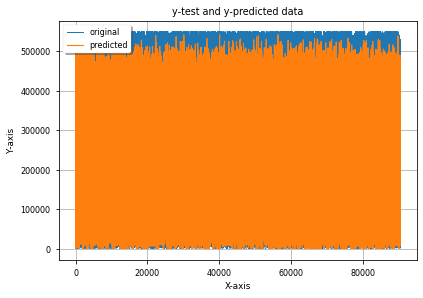

In [388]:
x_ax = range(len(y_test))
plt.plot(x_ax, y_test, linewidth=1, label="original")
plt.plot(x_ax, y_pred, linewidth=1.1, label="predicted")
plt.title("y-test and y-predicted data")
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.legend(loc='best',fancybox=True, shadow=True)
plt.grid(True)
plt.show() 

# Анализ feature importance

Feature: 0, Score: 60.11722
Feature: 1, Score: 869.37054
Feature: 2, Score: 16112.84631
Feature: 3, Score: -2.32373
Feature: 4, Score: 80244.91025
Feature: 5, Score: 0.29703
Feature: 6, Score: -1527.14507
Feature: 7, Score: 280.40009
Feature: 8, Score: 486.24134
Feature: 9, Score: -582.48997
Feature: 10, Score: 77.72838
Feature: 11, Score: -176.70960


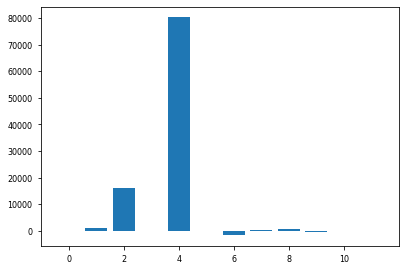

In [378]:
model = LinearRegression()
model.fit(X_train, y_train)
# get importance
importance = model.coef_[0]
# summarize feature importance
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
plt.bar([x for x in range(len(importance))], importance)
plt.show()

Text(0.5, 1.0, 'Feature Importance')

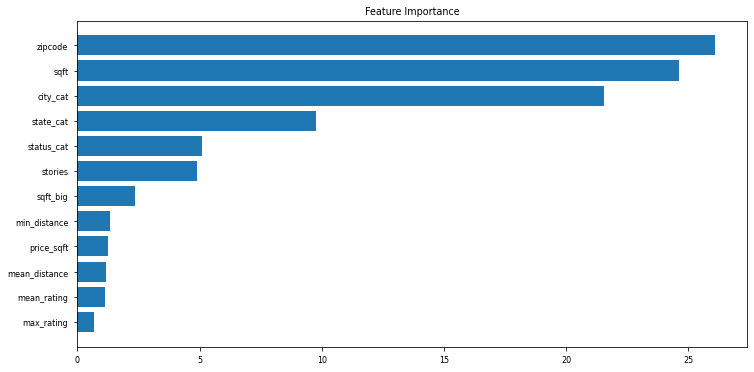

In [379]:
feature_importance=catboost.feature_importances_
sorted_idx=np.argsort(feature_importance)
fig=plt.figure(figsize=(12,6))
plt.barh(range(len(sorted_idx)),feature_importance[sorted_idx],align='center')
plt.yticks(range(len(sorted_idx)),np.array(X_test.columns)[sorted_idx])
plt.title('Feature Importance')